# Power an Polarization Calibration

**Authors**: Joaquín Andrés Porras, Jesús del Hoyo

**Date**:   23/05/2024

**Motivation**: VDOEST project

**Objective**:

Seleccionar una potencia inicial. Para ello, usamos una lámina lambda/2 y un cubo polarizador. También usamos un medidor de potencia y los motores que giran la lámina lambda/2

También calibramos las lambda/2 y la lambda/4 para el generador de estados



### Medidor de potencia

## Carga de módulos necesarios


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime                                     # Datetime
from time import sleep                              # Wait time
import numpy as np                                  # Numpy
import py_lab.utils as utils                        # Utils py-lab
from scipy.optimize import least_squares            # Least squares
from py_lab.setups.CLUR_laser.clur import CLUR           # CLUR Library
from py_lab.config import degrees                   # Units

## Inicialización de los objetos

In [3]:
clur = CLUR(cam = None, gimbal = None, stage = None)

('925808',)
1000
True

----------Data for S/N 925808 ---------------


In [4]:
clur.Open()

### Funciones previas

In [5]:
def model_cos2_2(par, angle):
    """Funcion cos**2 with parameters."""
    Imodel = par[0] + par[1] * np.cos(2*(angle - par[2]))**2
    return Imodel


def error_cos2_2(par, angle, Iexp):
    """Function that serves as optimization for cos**2."""
    Imodel = model_cos2_2(par, angle)
    dif = Iexp - Imodel
    return dif

In [6]:
# Obtención de escala
clur.pm.Print_Ranges()
range = clur.pm.Get_Range(verbose=True)

Rango  0  =  AUTO
Rango  1  =  3.00W
Rango  2  =  300mW
Rango  3  =  30.0mW
Rango  4  =  3.00mW
Rango  5  =  300uW
Escala:  3.00W


In [7]:
# Configuración de escala
clur.pm.Set_Range(range=1, verbose=True);

Escala:  3.00W
Background cleared!!!


### Motores

In [8]:
# Homing de los motores
pos = clur.rotator.Home(waiting='busy', verbose=True)

Current position is:
-  Motor 0: -0.0 deg.
-  Motor 1: 0.0 deg.
-  Motor 2: 0.0 deg.


In [9]:
# Comprobación de la posición inicial de los motores
pos = clur.rotator.Get_Position(units='deg', refered=True, verbose=True)

Current position is:
-  Motor 0: -0.0 deg.
-  Motor 1: 0.0 deg.
-  Motor 2: 0.0 deg.


## Calibración de potencia

In [10]:
n_measures = 91
angles = np.linspace(0, 90*degrees, n_measures)
Iexp = np.zeros(n_measures)

Primero tenemos que tomar la señal de referencia. Para ello, se enciende el láser, se deja un tiempo para que se estabilice la intensidad y SE TOMA UNA SEÑAL DIRECTAMENTE DEL LÁSER

In [11]:
# Medida de la señal de ruido
clur.pm.Get_Power(Nmeasures=16, average=True, is_background=True, verbose=True)

Power:  -0.001


-0.001

In [12]:
# Medida de la señal de referencia
clur.Get_Power_Reference(verbose=True)
I_ref = clur.power_ref
print(I_ref)

Power:  0.46453125000000006
0.46453125000000006


Ahora, colocamos el cubo polarizador entre el láser y el medidor de potencia, y medimos la intensidad a la salida. Dividiendo entre el valor de I_ref, obtendremos lo que atenúa el cubo polarizador

In [13]:
I_cube = clur.pm.Get_Power(Nmeasures=16, average=True, verbose=True)
cube_attenuation = 1 - (I_cube/I_ref)

Power:  0.4346875


In [14]:
print("El cubo polarizador atenúa un {:.2f} %.".format(cube_attenuation*100))

El cubo polarizador atenúa un 6.42 %.


Ahora, colocamos la lámina lambda/2 entre el láser y el cubo polarizador. Medimos cada X grados y guardamos todos los valores

In [15]:
# Bucle de medidas
utils.percentage_complete()

for ind, angle in enumerate(angles): 
    clur.rotator.Move_Absolute(pos = [0, 0, angle], units = 'rad')
    sleep(1)
    Iexp[ind] = clur.pm.Get_Power(Nmeasures=16, average=True, verbose=False)
    utils.percentage_complete(ind, n_measures)

### Análisis de medidas de potencia

Con estos valores, ajustamos a una función

 I = Imin + Imax * cos(2*(theta-theta_0))**2,
 
siendo theta el ángulo de giro de la lambda/2

In [16]:
# Obtención de parámetros de ajuste
(Imax, Imin) = (np.max(Iexp), np.min(Iexp))
bounds = ([0, 0, 0], [np.abs(1.1*+0.1), Imax, 90 * degrees])
par0 = [np.max((0,Imin)), Imax - Imin, np.random.rand() * 90 * degrees]
result = least_squares(error_cos2_2, par0, args=(angles, Iexp), bounds=bounds)
par = result.x

In [17]:
print(par)

[0.0022188  0.43335324 0.57996401]


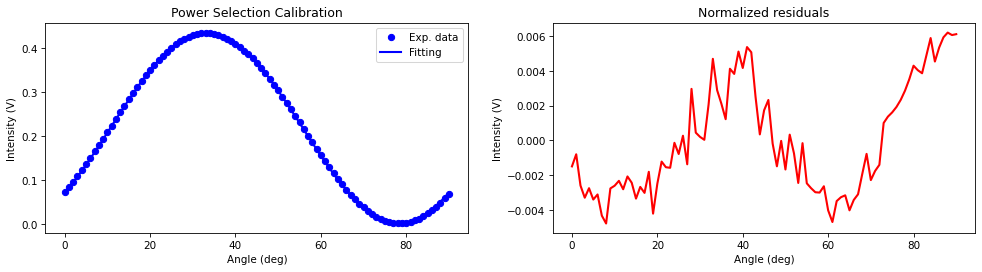

The normalized MSE is: 0.03 %.



In [18]:
# Representación de resultados experimentales con el ajuste realizado
Imodel = model_cos2_2(par, angles)
utils.plot_experiment_residuals_1D(angles, Iexp, Imodel, title='Power Selection Calibration')

###  Guardado de los datos en un archivo

In [19]:
Power_Calibration = dict()

In [20]:
Power_Calibration['I_ref'] = I_ref
Power_Calibration['angles'] = angles
Power_Calibration['Iexp'] = Iexp
Power_Calibration['par'] = par
Power_Calibration['n_measures'] = n_measures
Power_Calibration['power_meter range'] = range
Power_Calibration['cube_attenuation'] = cube_attenuation
Power_Calibration['date_exp'] = datetime.date.today()

In [21]:
%cd C:\Users\CLUR AOCG\Bitbucket\py_lab\py_lab\calibrations\clur

C:\Users\CLUR AOCG\Bitbucket\py_lab\py_lab\calibrations\clur


In [22]:
np.savez("Power_Calibration.npz", **Power_Calibration)

In [23]:
clur.Load_Power_Cal()

### Obtención de una potencia concreta

Ahora, indicamos la potencia que necesitamos en el experimento, y la lambda/2 gira en la posición en la cual se obtiene esa potencia

In [25]:
clur.Set_Power(0.2, units='W', verbose=True)

Power: 45.92%


## Calibración de la polarización

### Calibración de lambda/2

Para calibrar la lambda/2, colocamos la lámina entre dos polarizadores lineales orientados a 0º. De esta manera, obtenemos una intensidad al girar la lámina equivalente a: 

$I = I_{0} + I_{1} * cos^2[2*(\theta-\theta_0)],$
 
siendo theta el ángulo de giro de la lambda/2. El ángulo que tomamos como azimut corresponderá con el máximo del ajuste

In [26]:
# Configuración de escala
clur.pm.Set_Range(range=1, verbose=True);

Device is measuring:  False
Escala:  3.00W
Background cleared!!!


In [27]:
clur.Set_Power(0.3, units='W', verbose=True)

Power: 59.24%


In [39]:
n_measures = 91
angles = np.linspace(0, 90*degrees, n_measures)
Iexp_HPSG = np.zeros(n_measures)

In [40]:
# Bucle de medidas
utils.percentage_complete()

for ind, angle in enumerate(angles): 
    clur.rotator.Move_Absolute(pos = [0, angle, 0], units = 'rad')
    sleep(1)
    Iexp_HPSG[ind] = clur.pm.Get_Power(Nmeasures=16, average=True, verbose=False)
    utils.percentage_complete(ind, n_measures)


Completion:   0 %
  1 %/  2 %/  3 %/  4 %/  5 %/  6 %/  7 %/  8 %/  9 %/ 10 %/ 12 %/ 13 %/ 14 %/ 15 %/ 16 %/ 17 %/ 18 %/ 19 %/ 20 %/ 21 %/ 23 %/ 24 %/ 25 %/ 26 %/ 27 %/ 28 %/ 29 %/ 30 %/ 31 %/ 32 %/ 34 %/ 35 %/ 36 %/ 37 %/ 38 %/ 39 %/ 40 %/ 41 %/ 42 %/ 43 %/ 45 %/ 46 %/ 47 %/ 48 %/ 49 %/ 50 %/ 51 %/ 52 %/ 53 %/ 54 %/ 56 %/ 57 %/ 58 %/ 59 %/ 60 %/ 61 %/ 62 %/ 63 %/ 64 %/ 65 %/ 67 %/ 68 %/ 69 %/ 70 %/ 71 %/ 72 %/ 73 %/ 74 %/ 75 %/ 76 %/ 78 %/ 79 %/ 80 %/ 81 %/ 82 %/ 83 %/ 84 %/ 85 %/ 86 %/ 87 %/ 89 %/ 90 %/ 91 %/ 92 %/ 93 %/ 94 %/ 95 %/ 96 %/ 97 %/ 98 %/100 %/r


In [45]:
# Obtención de parámetros de ajuste
(Imax, Imin) = (np.max(Iexp_HPSG), np.min(Iexp_HPSG))
bounds = ([0, 0, 0], [0.01+np.abs(Imin), Imax, 90 * degrees])
par0 = [np.max((0,Imin)), Imax - Imin, np.random.rand() * 90 * degrees]
result = least_squares(error_cos2_2, par0, args=(angles, Iexp_HPSG), bounds=bounds)
par = result.x
angle_0_H = par[2]
print("El azimut de HPSG es: {:.2f} º".format(angle_0_H/degrees))

El azimut de HPSG es: 55.16 º


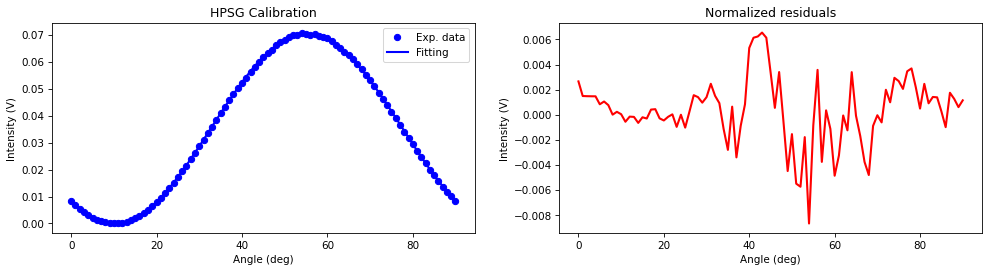

The normalized MSE is: 0.03 %.



In [46]:
# Representación de resultados experimentales con el ajuste realizado
Imodel_HPSG = model_cos2_2(par, angles)
utils.plot_experiment_residuals_1D(angles, Iexp_HPSG, Imodel_HPSG, title='HPSG Calibration')

Ahora vamos a calibrar la $\lambda/4$. Para ello, colocaremos la $\lambda/2$ con su verdadero acimut a 0º y rotaremos la $\lambda/4$ entre 0º y 180º para encontrar su ángulo de cero. En este caso la función que siga la intensidad será la misma, pero el $I'_0$ será más alto que en el caso anterior debido a la menor retardancia de la lámina.

In [47]:
n_measures = 91
angles = np.linspace(0, 90*degrees, n_measures)
Iexp_QPSG = np.zeros(n_measures)

In [48]:
# Bucle de medidas
utils.percentage_complete()

for ind, angle in enumerate(angles): 
    clur.rotator.Move_Absolute(pos = [angle, angle_0_H, 0], units = 'rad')
    sleep(1)
    Iexp_QPSG[ind] = clur.pm.Get_Power(Nmeasures=16, average=True, verbose=False)
    utils.percentage_complete(ind, n_measures)


Completion:   0 %
  1 %/  2 %/  3 %/  4 %/  5 %/  6 %/  7 %/  8 %/  9 %/ 10 %/ 12 %/ 13 %/ 14 %/ 15 %/ 16 %/ 17 %/ 18 %/ 19 %/ 20 %/ 21 %/ 23 %/ 24 %/ 25 %/ 26 %/ 27 %/ 28 %/ 29 %/ 30 %/ 31 %/ 32 %/ 34 %/ 35 %/ 36 %/ 37 %/ 38 %/ 39 %/ 40 %/ 41 %/ 42 %/ 43 %/ 45 %/ 46 %/ 47 %/ 48 %/ 49 %/ 50 %/ 51 %/ 52 %/ 53 %/ 54 %/ 56 %/ 57 %/ 58 %/ 59 %/ 60 %/ 61 %/ 62 %/ 63 %/ 64 %/ 65 %/ 67 %/ 68 %/ 69 %/ 70 %/ 71 %/ 72 %/ 73 %/ 74 %/ 75 %/ 76 %/ 78 %/ 79 %/ 80 %/ 81 %/ 82 %/ 83 %/ 84 %/ 85 %/ 86 %/ 87 %/ 89 %/ 90 %/ 91 %/ 92 %/ 93 %/ 94 %/ 95 %/ 96 %/ 97 %/ 98 %/100 %/r


In [49]:
# Obtención de parámetros de ajuste
(Imax, Imin) = (np.max(Iexp_QPSG), np.min(Iexp_QPSG))
bounds = ([0, 0, 0], [np.abs(Imin), Imax, 90 * degrees])
par0 = [np.max((0,Imin)), Imax - Imin, np.random.rand() * 90 * degrees]
result = least_squares(error_cos2_2, par0, args=(angles, Iexp_QPSG), bounds=bounds)
par = result.x
angle_0_Q = par[2]
print("El azimut de QPSG es: {:.2f} º".format(angle_0_Q/degrees))

El azimut de QPSG es: 64.12 º


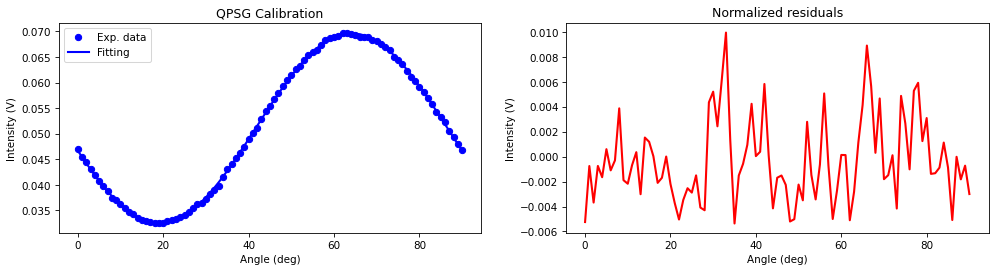

The normalized MSE is: 0.03 %.



In [50]:
# Representación de resultados experimentales con el ajuste realizado
Imodel_QPSG = model_cos2_2(par, angles)
utils.plot_experiment_residuals_1D(angles, Iexp_QPSG, Imodel_QPSG, title='QPSG Calibration')

In [52]:
# Comprobar que el acimut dado es el correcto y no acimut 
clur.rotator.Move_Absolute([angle_0_Q, angle_0_H, 0], units="rad"); # Si esta esta con el eje horizontal, es la buena
# Solo si en el movimiento anterior salia el eje vertical
# angle_0_Q = angle_0_Q + 90*degrees

In [53]:
# Save data
%cd C:\Users\CLUR AOCG\Bitbucket\py_lab\py_lab\calibrations\clur
np.savez("Polarization_Calibration.npz", angle_0_Q=angle_0_Q, angle_0_H=angle_0_H)

C:\Users\CLUR AOCG\Bitbucket\py_lab\py_lab\calibrations\clur


In [54]:
clur.Load_Polarization_Cal()

## Obtención de una polarización concreta

Vamos a fijar una polarización para verr si el resultado es el deseado. Se pueden probar configuraciones conocidas para ver cuánta energía sale. Por ejemplo: lineal a 0º o 90º, y circular.

In [55]:
clur.Set_Power(0.6)

In [60]:
clur.Set_Polarization(azimuth=0*degrees, ellipticity=45*degrees)

122.66263729756697 64.12167983381485


## Cierre de los objetos

### Medidor de potencia

In [26]:
# Stop de toma de medidas
clur.pm.Stop_Live()

In [27]:
# Cierre de los motores
clur.Close()

55.16263729756696 64.12167983381485
